# Создание нейросети с помощью NumPy

В этом ноутбуке мы:
1. Реализуем простой нейрон используя NumPy
2. Вычислим производные для обратного распространения
3. Создадим класс слоя, который сохраняет состояния необходимые для прямого и обратного прохода
4. Создадим нейросеть из нескольких слоев
5. Обучим сеть на реальном датасете (Breast Cancer) для бинарной классификации


In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

## 1. Реализация простого нейрона

Нейрон выполняет следующую операцию:
$$y = \sigma(w^T x + b)$$

где:
- $x$ - входной вектор
- $w$ - вектор весов
- $b$ - смещение
- $\sigma$ - функция активации (будем использовать сигмоиду)


In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def neuron_forward(x, w, b):
    z = np.dot(w, x) + b
    output = sigmoid(z)
    return output

x = np.array([1.0, 2.0, 3.0])
w = np.array([0.5, -0.2, 0.1])
b = 0.3

output = neuron_forward(x, w, b)
print(f"Input: {x}")
print(f"Weights: {w}")
print(f"Bias: {b}")
print(f"Output: {output:.4f}")


Input: [1. 2. 3.]
Weights: [ 0.5 -0.2  0.1]
Bias: 0.3
Output: 0.6682


## 2. Вычисление производных для обратного распространения

Для обратного распространения нам нужно вычислить градиенты:

**Производная сигмоиды:**
$$\frac{\partial \sigma}{\partial z} = \sigma(z) \cdot (1 - \sigma(z))$$

**Градиенты по параметрам:**
- $\frac{\partial L}{\partial w} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial z} \cdot \frac{\partial z}{\partial w} = \frac{\partial L}{\partial y} \cdot \sigma'(z) \cdot x$
- $\frac{\partial L}{\partial b} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial z} \cdot \frac{\partial z}{\partial b} = \frac{\partial L}{\partial y} \cdot \sigma'(z)$


In [6]:
def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def neuron_backward(x, w, b, dy):
    z = np.dot(w, x) + b
    dz = dy * sigmoid_derivative(z)
    dw = dz * x
    db = dz
    dx = dz * w
    return dw, db, dx

x = np.array([1.0, 2.0, 3.0])
w = np.array([0.5, -0.2, 0.1])
b = 0.3
dy = 1.0

dw, db, dx = neuron_backward(x, w, b, dy)
print(f"Gradient w.r.t. weights: {dw}")
print(f"Gradient w.r.t. bias: {db:.4f}")
print(f"Gradient w.r.t. input: {dx}")


Gradient w.r.t. weights: [0.22171287 0.44342575 0.66513862]
Gradient w.r.t. bias: 0.2217
Gradient w.r.t. input: [ 0.11085644 -0.04434257  0.02217129]


## 3. Класс слоя нейронов с управлением состоянием

Теперь создадим класс слоя, который:
- Содержит несколько нейронов (принимает n_features входов и возвращает n_outputs выходов)
- Хранит параметры (матрицу весов и вектор смещений)
- Кэширует промежуточные значения во время прямого прохода
- Использует кэшированные значения для эффективного обратного прохода
- Реализует обновление параметров


In [17]:
class Layer:
    def __init__(self, n_inputs, n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = np.random.randn(n_inputs, n_outputs) * 0.01
        self.b = np.zeros(n_outputs)
        self.cache = {}
        
    def forward(self, x):
        z = np.dot(x, self.W) + self.b
        output = sigmoid(z)
        self.cache['x'] = x
        self.cache['z'] = z
        self.cache['output'] = output
        return output
    
    def backward(self, dy):
        x = self.cache['x']
        output = self.cache['output']
        dz = dy * output * (1 - output)
        
        if x.ndim == 1:
            self.dW = np.outer(x, dz)
            self.db = dz
            dx = np.dot(dz, self.W.T)
        else:
            batch_size = x.shape[0]
            self.dW = np.dot(x.T, dz) / batch_size
            self.db = np.mean(dz, axis=0)
            dx = np.dot(dz, self.W.T)
        
        return dx
    
    def update_parameters(self, learning_rate):
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db
    
    def get_parameters(self):
        return {'W': self.W.copy(), 'b': self.b.copy()}


## 4. Пример использования класса


In [18]:
layer = Layer(n_inputs=3, n_outputs=2)

x = np.array([1.0, 2.0, 3.0])
output = layer.forward(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Output: {output}")

dy = np.ones(2)
dx = layer.backward(dy)
print(f"Градиент по входу: {dx}")

layer.update_parameters(learning_rate=0.1)
params = layer.get_parameters()
print(f"Размер матрицы весов: {params['W'].shape}")
print(f"Размер вектора смещений: {params['b'].shape}")


Input shape: (3,)
Output shape: (2,)
Output: [0.50272405 0.50551324]
Градиент по входу: [ 0.00089613  0.00542628 -0.00117064]
Размер матрицы весов: (3, 2)
Размер вектора смещений: (2,)


## 5. Создание нейросети из нескольких слоев

Теперь создадим класс нейросети, которая будет:
- Состоять из нескольких слоев
- Последовательно выполнять прямой проход через все слои
- Последовательно выполнять обратный проход через все слои (в обратном порядке)
- Обновлять параметры всех слоев


In [19]:
class NeuralNetwork:
    def __init__(self, layer_sizes):
        self.layers = []
        for i in range(len(layer_sizes) - 1):
            layer = Layer(layer_sizes[i], layer_sizes[i + 1])
            self.layers.append(layer)
    
    def forward(self, x):
        output = x
        for layer in self.layers:
            output = layer.forward(output)
        return output
    
    def backward(self, dy):
        dx = dy
        for layer in reversed(self.layers):
            dx = layer.backward(dx)
        return dx
    
    def update_parameters(self, learning_rate):
        for layer in self.layers:
            layer.update_parameters(learning_rate)
    
    def get_all_parameters(self):
        params = []
        for i, layer in enumerate(self.layers):
            params.append({
                'layer': i,
                'parameters': layer.get_parameters()
            })
        return params


## 6. Пример использования нейросети


In [20]:
network = NeuralNetwork([4, 8, 3, 1])

print("Архитектура сети:")
for i, layer in enumerate(network.layers):
    print(f"  Слой {i+1}: {layer.n_inputs} -> {layer.n_outputs}")

x = np.array([1.0, 2.0, 3.0, 4.0])
output = network.forward(x)
print(f"\nВход: {x}")
print(f"Выход сети: {output}")

dy = np.array([1.0])
dx = network.backward(dy)
print(f"\nГрадиент по входу: {dx}")

network.update_parameters(learning_rate=0.01)
print("\nПараметры обновлены!")


Архитектура сети:
  Слой 1: 4 -> 8
  Слой 2: 8 -> 3
  Слой 3: 3 -> 1

Вход: [1. 2. 3. 4.]
Выход сети: [0.49813753]

Градиент по входу: [ 3.77140949e-08 -2.51994577e-08 -2.51787580e-08  6.49271135e-08]

Параметры обновлены!


## 7. Обучение на реальном датасете (Breast Cancer)

Обучим нашу сеть на датасете Wisconsin Breast Cancer для бинарной классификации опухолей (доброкачественная/злокачественная) по 30 признакам


In [21]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Количество признаков: {X_train.shape[1]}")
print(f"Распределение классов в обучающей выборке:")
print(f"  Класс 0 (злокачественная): {np.sum(y_train == 0)}")
print(f"  Класс 1 (доброкачественная): {np.sum(y_train == 1)}")


Размер обучающей выборки: (455, 30)
Размер тестовой выборки: (114, 30)
Количество признаков: 30
Распределение классов в обучающей выборке:
  Класс 0 (злокачественная): 169
  Класс 1 (доброкачественная): 286


In [22]:
def binary_cross_entropy_loss(y_pred, y_true):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_grad(y_pred, y_true):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return (y_pred - y_true) / (y_pred * (1 - y_pred) + epsilon)

def accuracy(y_pred, y_true):
    predictions = (y_pred > 0.5).astype(int)
    return np.mean(predictions == y_true)


In [27]:
network = NeuralNetwork([30, 1])

train_losses = []
train_accuracies = []
test_accuracies = []
epochs = 200
learning_rate = 0.01

for epoch in range(epochs):
    total_loss = 0
    
    for i in range(len(X_train)):
        x = X_train[i]
        y_true = y_train[i]
        
        y_pred = network.forward(x)
        loss = binary_cross_entropy_loss(y_pred, y_true)
        total_loss += loss
        
        grad = binary_cross_entropy_grad(y_pred, y_true)
        network.backward(grad)
        network.update_parameters(learning_rate)
    
    avg_loss = total_loss / len(X_train)
    train_losses.append(avg_loss)
    
    train_preds = np.array([network.forward(x) for x in X_train])
    train_acc = accuracy(train_preds, y_train)
    train_accuracies.append(train_acc)
    
    test_preds = np.array([network.forward(x) for x in X_test])
    test_acc = accuracy(test_preds, y_test)
    test_accuracies.append(test_acc)
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

print(f"\nФинальная точность на обучающей выборке: {train_accuracies[-1]:.4f}")
print(f"Финальная точность на тестовой выборке: {test_accuracies[-1]:.4f}")


Epoch 0, Loss: 0.2221, Train Acc: 0.9692, Test Acc: 0.9737
Epoch 20, Loss: 0.0634, Train Acc: 0.9868, Test Acc: 0.9912
Epoch 40, Loss: 0.0561, Train Acc: 0.9868, Test Acc: 0.9912
Epoch 60, Loss: 0.0528, Train Acc: 0.9868, Test Acc: 0.9912
Epoch 80, Loss: 0.0507, Train Acc: 0.9868, Test Acc: 0.9825
Epoch 100, Loss: 0.0492, Train Acc: 0.9868, Test Acc: 0.9825
Epoch 120, Loss: 0.0480, Train Acc: 0.9868, Test Acc: 0.9825
Epoch 140, Loss: 0.0470, Train Acc: 0.9868, Test Acc: 0.9825
Epoch 160, Loss: 0.0461, Train Acc: 0.9890, Test Acc: 0.9825
Epoch 180, Loss: 0.0453, Train Acc: 0.9912, Test Acc: 0.9825

Финальная точность на обучающей выборке: 0.9912
Финальная точность на тестовой выборке: 0.9825


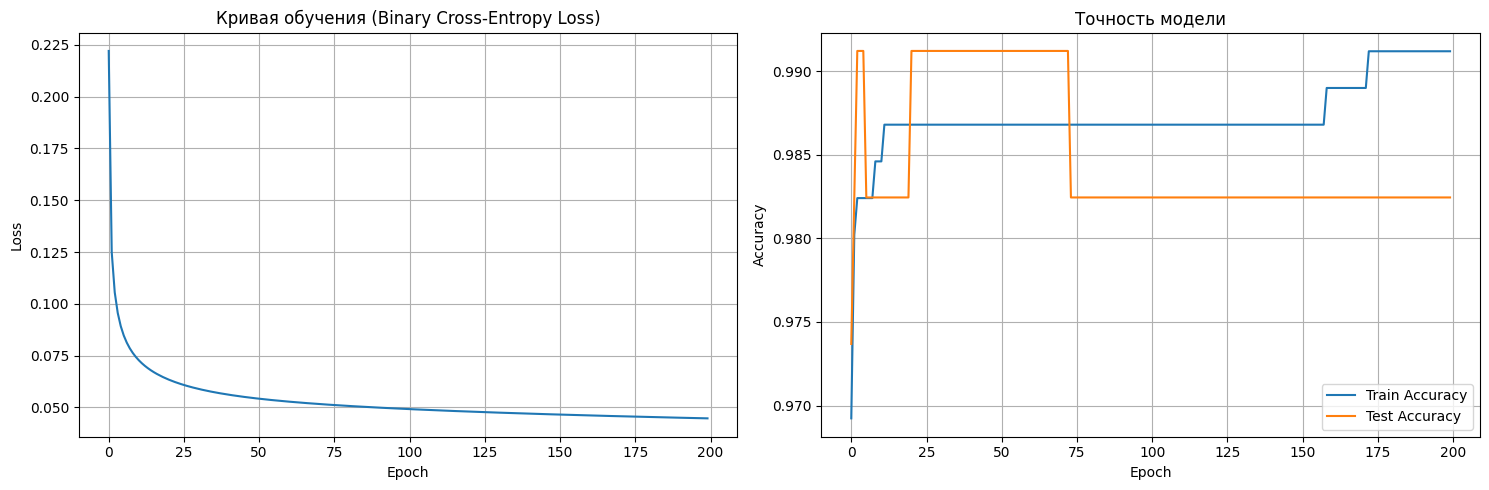

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Кривая обучения (Binary Cross-Entropy Loss)')
axes[0].grid(True)

axes[1].plot(train_accuracies, label='Train Accuracy')
axes[1].plot(test_accuracies, label='Test Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Точность модели')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
